In [251]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from gym.envs.toy_text import frozen_lake
from gym.envs.toy_text import taxi
import time

In [2]:
# https://github.com/dennybritz/reinforcement-learning/blob/master/DP/Value%20Iteration%20Solution.ipynb
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    iterationCount = 0
    deltas = []
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
            iterationCount += 1
            deltas.append(delta)
            #print "%-4d: %f" %(iterationCount, delta)
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    return policy, V, iterationCount

In [3]:
# https://github.com/dennybritz/reinforcement-learning/blob/master/DP/Policy%20Iteration%20Solution.ipynb
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    iterationCount = 0
    while True:
        iterationCount += 1
        #print iterationCount
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the currect policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V, iterationCount

In [4]:
frozen_lake.FrozenLakeEnv().render()


SFFF
FHFH
FFFH
HFFG


In [5]:
taxi.TaxiEnv().render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
print frozen_lake.FrozenLakeEnv().nS
print taxi.TaxiEnv().nS

16
500


In [7]:
%timeit print value_iteration(frozen_lake.FrozenLakeEnv())

(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([0.82182145, 0.82126109, 0.82087163, 0.82067347, 0.82199325,
       0.        , 0.52824715, 0.        , 0.82226231, 0.82260733,
       0.76389785, 0.        , 0.        , 0.88171208, 0.94085038,
       0.        ]), 2976)
(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0.

(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([0.82182145, 0.82126109, 0.82087163, 0.82067347, 0.82199325,
       0.        , 0.52824715, 0.        , 0.82226231, 0.82260733,
       0.76389785, 0.        , 0.        , 0.88171208, 0.94085038,
       0.        ]), 2976)
(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0.

(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([0.82182145, 0.82126109, 0.82087163, 0.82067347, 0.82199325,
       0.        , 0.52824715, 0.        , 0.82226231, 0.82260733,
       0.76389785, 0.        , 0.        , 0.88171208, 0.94085038,
       0.        ]), 2976)
(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0.

In [8]:
%timeit print policy_improvement(frozen_lake.FrozenLakeEnv())

(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([0.8233628 , 0.82330813, 0.82327014, 0.82325081, 0.82337956,
       0.        , 0.52929815, 0.        , 0.8234058 , 0.82343946,
       0.76462706, 0.        , 0.        , 0.88229042, 0.94114466,
       0.        ]), 3)
(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0

(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([0.8233628 , 0.82330813, 0.82327014, 0.82325081, 0.82337956,
       0.        , 0.52929815, 0.        , 0.8234058 , 0.82343946,
       0.76462706, 0.        , 0.        , 0.88229042, 0.94114466,
       0.        ]), 3)
(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0

(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([0.8233628 , 0.82330813, 0.82327014, 0.82325081, 0.82337956,
       0.        , 0.52929815, 0.        , 0.8234058 , 0.82343946,
       0.76462706, 0.        , 0.        , 0.88229042, 0.94114466,
       0.        ]), 3)
(array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0

In [10]:
%timeit print value_iteration(taxi.TaxiEnv(), theta=0.0001, discount_factor=0.99)

(array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]]), array([1978.99015022, 1857.32747932, 1897.06925501, 1837.75400852,
       1742.78487492, 1857.32747932, 1706.1131777 , 1761.39857683,
       1818.37675805, 1742.78468664, 1897.06925501, 1761.39857683,
       1706.11336411, 1742.78468664, 1706.1131777 , 1837.75400852,
       1999.99015022, 1877.09856246, 1917.24177122, 1857.32738082,
       1958.20024872, 1837.75420453, 1877.09856246, 1818.37646843,
       1761.39895723, 1877.09856246, 1724.35683977, 1780.20068017,
       1799.19299047, 1724.35683977, 1877.09856246, 1742.78459106,
       1724.35702617, 1761.39876894, 1724.35683977, 1857.32738082,
       1978.99024872, 1897.06935351, 1897.06935351, 1877.09846396,
       1897.06954756, 1780.20087228, 1818.37666248, 1761.39867337,
       1818.37685267, 1937.61805022, 1780.20087228

(array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]]), array([1978.99015022, 1857.32747932, 1897.06925501, 1837.75400852,
       1742.78487492, 1857.32747932, 1706.1131777 , 1761.39857683,
       1818.37675805, 1742.78468664, 1897.06925501, 1761.39857683,
       1706.11336411, 1742.78468664, 1706.1131777 , 1837.75400852,
       1999.99015022, 1877.09856246, 1917.24177122, 1857.32738082,
       1958.20024872, 1837.75420453, 1877.09856246, 1818.37646843,
       1761.39895723, 1877.09856246, 1724.35683977, 1780.20068017,
       1799.19299047, 1724.35683977, 1877.09856246, 1742.78459106,
       1724.35702617, 1761.39876894, 1724.35683977, 1857.32738082,
       1978.99024872, 1897.06935351, 1897.06935351, 1877.09846396,
       1897.06954756, 1780.20087228, 1818.37666248, 1761.39867337,
       1818.37685267, 1937.61805022, 1780.20087228

(array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]]), array([1978.99015022, 1857.32747932, 1897.06925501, 1837.75400852,
       1742.78487492, 1857.32747932, 1706.1131777 , 1761.39857683,
       1818.37675805, 1742.78468664, 1897.06925501, 1761.39857683,
       1706.11336411, 1742.78468664, 1706.1131777 , 1837.75400852,
       1999.99015022, 1877.09856246, 1917.24177122, 1857.32738082,
       1958.20024872, 1837.75420453, 1877.09856246, 1818.37646843,
       1761.39895723, 1877.09856246, 1724.35683977, 1780.20068017,
       1799.19299047, 1724.35683977, 1877.09856246, 1742.78459106,
       1724.35702617, 1761.39876894, 1724.35683977, 1857.32738082,
       1978.99024872, 1897.06935351, 1897.06935351, 1877.09846396,
       1897.06954756, 1780.20087228, 1818.37666248, 1761.39867337,
       1818.37685267, 1937.61805022, 1780.20087228

(array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]]), array([1978.99015022, 1857.32747932, 1897.06925501, 1837.75400852,
       1742.78487492, 1857.32747932, 1706.1131777 , 1761.39857683,
       1818.37675805, 1742.78468664, 1897.06925501, 1761.39857683,
       1706.11336411, 1742.78468664, 1706.1131777 , 1837.75400852,
       1999.99015022, 1877.09856246, 1917.24177122, 1857.32738082,
       1958.20024872, 1837.75420453, 1877.09856246, 1818.37646843,
       1761.39895723, 1877.09856246, 1724.35683977, 1780.20068017,
       1799.19299047, 1724.35683977, 1877.09856246, 1742.78459106,
       1724.35702617, 1761.39876894, 1724.35683977, 1857.32738082,
       1978.99024872, 1897.06935351, 1897.06935351, 1877.09846396,
       1897.06954756, 1780.20087228, 1818.37666248, 1761.39867337,
       1818.37685267, 1937.61805022, 1780.20087228

In [337]:
taxi_policy, taxi_values, taxi_iters = value_iteration(taxi.TaxiEnv(), theta=0.0001, discount_factor=0.99)

In [11]:
%timeit print policy_improvement(taxi.TaxiEnv(), discount_factor=0.99)

(array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]]), array([1978.99901398, 1857.33625444, 1897.07811877, 1837.76287228,
       1742.79321998, 1857.33625444, 1706.12160705, 1761.4072642 ,
       1818.38527255, 1742.79320113, 1897.07811877, 1761.4072642 ,
       1706.12162571, 1742.79320113, 1706.12160705, 1837.76287228,
       1999.99901398, 1877.10733758, 1917.25063498, 1857.33624458,
       1958.20902384, 1837.7628919 , 1877.10733758, 1818.38524355,
       1761.40730228, 1877.10733758, 1724.36526912, 1780.20936754,
       1799.20141982, 1724.36526912, 1877.10733758, 1742.79319156,
       1724.36528778, 1761.40728344, 1724.36526912, 1857.33624458,
       1978.99902384, 1897.07812863, 1897.07812863, 1877.10732772,
       1897.07814805, 1780.20938678, 1818.38526298, 1761.40727387,
       1818.38528202, 1937.62691398, 1780.20938678

(array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]]), array([1978.99901398, 1857.33625444, 1897.07811877, 1837.76287228,
       1742.79321998, 1857.33625444, 1706.12160705, 1761.4072642 ,
       1818.38527255, 1742.79320113, 1897.07811877, 1761.4072642 ,
       1706.12162571, 1742.79320113, 1706.12160705, 1837.76287228,
       1999.99901398, 1877.10733758, 1917.25063498, 1857.33624458,
       1958.20902384, 1837.7628919 , 1877.10733758, 1818.38524355,
       1761.40730228, 1877.10733758, 1724.36526912, 1780.20936754,
       1799.20141982, 1724.36526912, 1877.10733758, 1742.79319156,
       1724.36528778, 1761.40728344, 1724.36526912, 1857.33624458,
       1978.99902384, 1897.07812863, 1897.07812863, 1877.10732772,
       1897.07814805, 1780.20938678, 1818.38526298, 1761.40727387,
       1818.38528202, 1937.62691398, 1780.20938678

(array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]]), array([1978.99901398, 1857.33625444, 1897.07811877, 1837.76287228,
       1742.79321998, 1857.33625444, 1706.12160705, 1761.4072642 ,
       1818.38527255, 1742.79320113, 1897.07811877, 1761.4072642 ,
       1706.12162571, 1742.79320113, 1706.12160705, 1837.76287228,
       1999.99901398, 1877.10733758, 1917.25063498, 1857.33624458,
       1958.20902384, 1837.7628919 , 1877.10733758, 1818.38524355,
       1761.40730228, 1877.10733758, 1724.36526912, 1780.20936754,
       1799.20141982, 1724.36526912, 1877.10733758, 1742.79319156,
       1724.36528778, 1761.40728344, 1724.36526912, 1857.33624458,
       1978.99902384, 1897.07812863, 1897.07812863, 1877.10732772,
       1897.07814805, 1780.20938678, 1818.38526298, 1761.40727387,
       1818.38528202, 1937.62691398, 1780.20938678

(array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]]), array([1978.99901398, 1857.33625444, 1897.07811877, 1837.76287228,
       1742.79321998, 1857.33625444, 1706.12160705, 1761.4072642 ,
       1818.38527255, 1742.79320113, 1897.07811877, 1761.4072642 ,
       1706.12162571, 1742.79320113, 1706.12160705, 1837.76287228,
       1999.99901398, 1877.10733758, 1917.25063498, 1857.33624458,
       1958.20902384, 1837.7628919 , 1877.10733758, 1818.38524355,
       1761.40730228, 1877.10733758, 1724.36526912, 1780.20936754,
       1799.20141982, 1724.36526912, 1877.10733758, 1742.79319156,
       1724.36528778, 1761.40728344, 1724.36526912, 1857.33624458,
       1978.99902384, 1897.07812863, 1897.07812863, 1877.10732772,
       1897.07814805, 1780.20938678, 1818.38526298, 1761.40727387,
       1818.38528202, 1937.62691398, 1780.20938678

In [339]:
taxi_policy_pi, taxi_values_pi, taxi_iters_pi = policy_improvement(taxi.TaxiEnv(), discount_factor=0.99)

In [345]:
def test_policy(env, policy, episodes=1000, max_iters=100):
    rewards = []
    for _ in range(episodes):
        env.reset()
        r = 0
        done = False
        iters = 0
        while not done:
            if iters > max_iters: break
            iters += 1
            a = np.argmax(policy[env.s])
            ob, reward, done, prob = env.step(a)
            r += reward
        rewards.append(r)
    return np.mean(rewards)

In [326]:
policy = [[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]
env = frozen_lake.FrozenLakeEnv()
test_policy(env, policy)

0.743

In [347]:
test_policy(taxi.TaxiEnv(), taxi_policy, episodes=1000000)

8.456455

In [348]:
test_policy(taxi.TaxiEnv(), taxi_policy_pi, episodes=1000000)

8.462363

In [302]:
class QAgent(object):
    def __init__(self, env, gamma=0.99, alpha=0.2, alpha_decay=1e-3, epsilon=1, epsilon_decay=1e-3):
        self.env = env
        self.Q = {s : {a : 0.5 for a in range(env.action_space.n)} for s in range(env.observation_space.n)}
        self.gamma = gamma
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.max_change = 0
        
    def train(self, convergence_threshold=1e-5, max_iters=5000):
        while True:
            ob = self.env.reset()
            agent.max_change = 0
            ob_seq = [ob]
            previous_ob = None
            action = None
            reward = 0
            iters = 0
            while True:
                if iters > max_iters: break
                iters += 1
                action = agent.act(previous_ob, action, ob, reward)
                previous_ob = ob
                ob, reward, done, prob = self.env.step(action)
                ob_seq.append(ob)
                if done:
                    agent.act(previous_ob, action, ob, reward, terminal=True) #final update
                    break
            agent.decay()
            if agent.max_change < convergence_threshold:
                break

    def act(self, previous_observation, previous_action, observation, reward, terminal=False):
        maxA, maxV = max([(a,v) for a,v in self.Q[observation].iteritems()], key=lambda x: x[1])
        if terminal: maxV = 0
        if previous_observation is not None and previous_action is not None:
            prev = self.Q[previous_observation][previous_action]
            self.Q[previous_observation][previous_action] = \
                (1 - self.alpha) * self.Q[previous_observation][previous_action] + \
                self.alpha * (reward + self.gamma * maxV)
            self.max_change = max(self.max_change, abs(prev - self.Q[previous_observation][previous_action]))
        if np.random.random() < self.epsilon:
            chosenA = self.env.action_space.sample()
        else:
            chosenA = maxA
        return chosenA
    
    def decay(self, parameter='both'):
        if parameter=='alpha' or parameter=='both':
            self.alpha *= (1-self.alpha_decay)
        if parameter=='epsilon' or parameter=='both':
            self.epsilon *= (1-self.epsilon_decay)
            
    def run(self, n_trials=1, max_iters=100):
        rewards = []
        for _ in range(n_trials):
            self.env.reset()
            done = False
            iters = 0
            r = 0
            while not done:
                if iters > max_iters: break
                iters += 1
                a, _ = max([(a,v) for a,v in self.Q[env.s].iteritems()], key=lambda x: x[1])
                #print self.env.s
                ob, reward, done, prob = self.env.step(a)
                r += reward
            #print self.env.s, reward
            rewards.append(r)
        return rewards

In [260]:
lake_data = []
env = frozen_lake.FrozenLakeEnv()
for ep in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#for ep in [0]:
    for al in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]:
        print "e: %f   a: %f" % (ep, al)
        agent = QAgent(env, epsilon=ep, alpha=al)
        start = time.time()
        agent.train()
        trainTime = time.time() - start
        trainScore = np.mean(agent.run(1000))
        lake_data.append({"alpha": al, "epsilon": ep, "trainTime": trainTime, "trainScore": trainScore})
env.close()

e: 0.000000   a: 0.000000
e: 0.000000   a: 0.050000
e: 0.000000   a: 0.100000
e: 0.000000   a: 0.150000
e: 0.000000   a: 0.200000
e: 0.000000   a: 0.250000
e: 0.000000   a: 0.300000
e: 0.000000   a: 0.350000
e: 0.000000   a: 0.400000
e: 0.000000   a: 0.450000
e: 0.000000   a: 0.500000
e: 0.000000   a: 0.550000
e: 0.000000   a: 0.600000
e: 0.000000   a: 0.650000
e: 0.000000   a: 0.700000
e: 0.000000   a: 0.750000
e: 0.000000   a: 0.800000
e: 0.000000   a: 0.850000
e: 0.000000   a: 0.900000
e: 0.000000   a: 0.950000
e: 0.000000   a: 1.000000
e: 0.100000   a: 0.000000
e: 0.100000   a: 0.050000
e: 0.100000   a: 0.100000
e: 0.100000   a: 0.150000
e: 0.100000   a: 0.200000
e: 0.100000   a: 0.250000
e: 0.100000   a: 0.300000
e: 0.100000   a: 0.350000
e: 0.100000   a: 0.400000
e: 0.100000   a: 0.450000
e: 0.100000   a: 0.500000
e: 0.100000   a: 0.550000
e: 0.100000   a: 0.600000
e: 0.100000   a: 0.650000
e: 0.100000   a: 0.700000
e: 0.100000   a: 0.750000
e: 0.100000   a: 0.800000
e: 0.100000 

Text(0,0.5,'average reward')

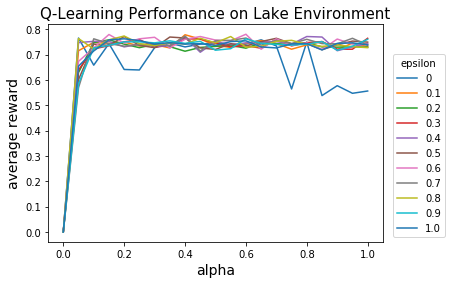

In [298]:
for ep in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    data = [d for d in lake_data if d['epsilon']==ep]
    pyplot.plot([d['alpha'] for d in data], [d['trainScore'] for d in data])
pyplot.legend([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], loc=(1.03, 0.02), title="epsilon")
pyplot.title("Q-Learning Performance on Lake Environment", fontsize=15)
pyplot.xlabel("alpha", fontsize=14)
pyplot.ylabel("average reward", fontsize=14)
#pyplot.plot([d['alpha'] for d in lake_data], [d['trainTime'] for d in lake_data])

Text(0,0.5,'average reward')

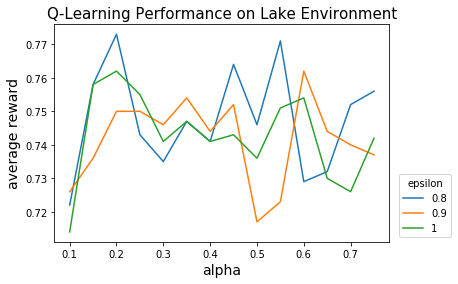

In [334]:
for ep in [0.8, 0.9, 1]:
    data = [d for d in lake_data if d['epsilon']==ep]
    pyplot.plot([d['alpha'] for d in data][2:16], [d['trainScore'] for d in data][2:16])
pyplot.legend([0.8, 0.9, 1], loc=(1.03, 0.02), title="epsilon")
pyplot.title("Q-Learning Performance on Lake Environment", fontsize=15)
pyplot.xlabel("alpha", fontsize=14)
pyplot.ylabel("average reward", fontsize=14)

Text(0,0.5,'seconds')

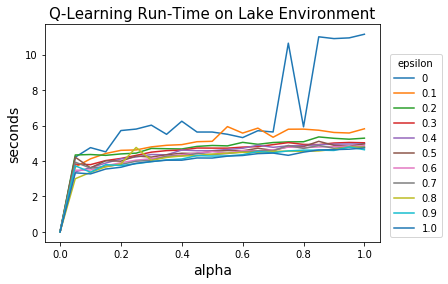

In [300]:
for ep in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    data = [d for d in lake_data if d['epsilon']==ep]
    pyplot.plot([d['alpha'] for d in data], [d['trainTime'] for d in data])
pyplot.legend([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], loc=(1.03, 0.02), title="epsilon")
pyplot.title("Q-Learning Run-Time on Lake Environment", fontsize=15)
pyplot.xlabel("alpha", fontsize=14)
pyplot.ylabel("seconds", fontsize=14)

In [269]:
env = frozen_lake.FrozenLakeEnv()
agent = QAgent(env, epsilon=ep, alpha=al)
start = time.time()
agent.train()
trainTime = time.time() - start
trainScore = np.mean(agent.run(1000))
print trainScore, trainTime

0.738 4.73475885391


In [303]:
taxi_data_bak = taxi_data[:]

In [304]:
taxi_data = []
env = taxi.TaxiEnv()
for ep in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#for ep in [0]:
    for al in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]:
        print "e: %f   a: %f" % (ep, al)
        agent = QAgent(env, epsilon=ep, alpha=al)
        start = time.time()
        agent.train()
        trainTime = time.time() - start
        trainScore = np.mean(agent.run(1000))
        taxi_data.append({"alpha": al, "epsilon": ep, "trainTime": trainTime, "trainScore": trainScore})
env.close()

e: 0.000000   a: 0.000000
e: 0.000000   a: 0.050000
e: 0.000000   a: 0.100000
e: 0.000000   a: 0.150000
e: 0.000000   a: 0.200000
e: 0.000000   a: 0.250000
e: 0.000000   a: 0.300000
e: 0.000000   a: 0.350000
e: 0.000000   a: 0.400000
e: 0.000000   a: 0.450000
e: 0.000000   a: 0.500000
e: 0.000000   a: 0.550000
e: 0.000000   a: 0.600000
e: 0.000000   a: 0.650000
e: 0.000000   a: 0.700000
e: 0.000000   a: 0.750000
e: 0.000000   a: 0.800000
e: 0.000000   a: 0.850000
e: 0.000000   a: 0.900000
e: 0.000000   a: 0.950000
e: 0.000000   a: 1.000000
e: 0.100000   a: 0.000000
e: 0.100000   a: 0.050000
e: 0.100000   a: 0.100000
e: 0.100000   a: 0.150000
e: 0.100000   a: 0.200000
e: 0.100000   a: 0.250000
e: 0.100000   a: 0.300000
e: 0.100000   a: 0.350000
e: 0.100000   a: 0.400000
e: 0.100000   a: 0.450000
e: 0.100000   a: 0.500000
e: 0.100000   a: 0.550000
e: 0.100000   a: 0.600000
e: 0.100000   a: 0.650000
e: 0.100000   a: 0.700000
e: 0.100000   a: 0.750000
e: 0.100000   a: 0.800000
e: 0.100000 

Text(0,0.5,'average reward')

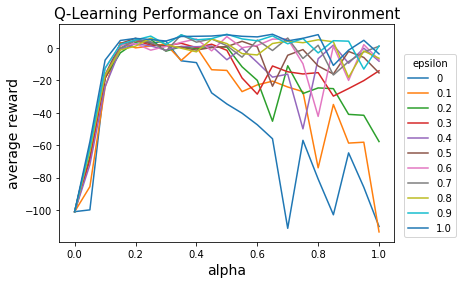

In [305]:
for ep in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    data = [d for d in taxi_data if d['epsilon']==ep]
    pyplot.plot([d['alpha'] for d in data], [d['trainScore'] for d in data])
pyplot.legend([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], loc=(1.03, 0.02), title="epsilon")
pyplot.title("Q-Learning Performance on Taxi Environment", fontsize=15)
pyplot.xlabel("alpha", fontsize=14)
pyplot.ylabel("average reward", fontsize=14)

Text(0,0.5,'average reward')

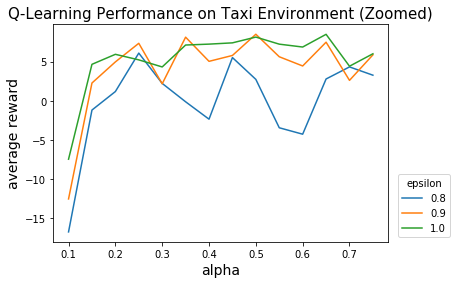

In [311]:
for ep in [0.8, 0.9, 1.0]:
    data = [d for d in taxi_data if d['epsilon']==ep]
    pyplot.plot([d['alpha'] for d in data][2:16], [d['trainScore'] for d in data][2:16])
pyplot.legend([0.8, 0.9, 1.0], loc=(1.03, 0.02), title="epsilon")
pyplot.title("Q-Learning Performance on Taxi Environment (Zoomed)", fontsize=15)
pyplot.xlabel("alpha", fontsize=14)
pyplot.ylabel("average reward", fontsize=14)

In [349]:
data = [d for d in taxi_data if d['epsilon']==1]
data[8:16]

[{'alpha': 0.4,
  'epsilon': 1.0,
  'trainScore': 7.241,
  'trainTime': 2.1023571491241455},
 {'alpha': 0.45,
  'epsilon': 1.0,
  'trainScore': 7.403,
  'trainTime': 1.9249579906463623},
 {'alpha': 0.5,
  'epsilon': 1.0,
  'trainScore': 8.141,
  'trainTime': 1.9925189018249512},
 {'alpha': 0.55,
  'epsilon': 1.0,
  'trainScore': 7.237,
  'trainTime': 1.6398530006408691},
 {'alpha': 0.6,
  'epsilon': 1.0,
  'trainScore': 6.869,
  'trainTime': 1.7275810241699219},
 {'alpha': 0.65,
  'epsilon': 1.0,
  'trainScore': 8.494,
  'trainTime': 1.7579970359802246},
 {'alpha': 0.7,
  'epsilon': 1.0,
  'trainScore': 4.416,
  'trainTime': 1.3789749145507812},
 {'alpha': 0.75,
  'epsilon': 1.0,
  'trainScore': 6.007,
  'trainTime': 1.490821123123169}]

Text(0,0.5,'seconds')

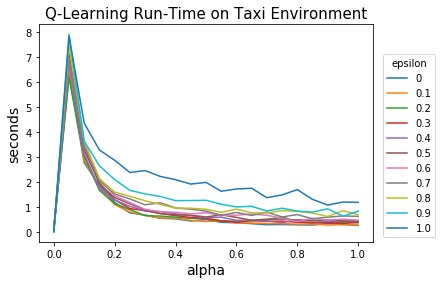

In [306]:
for ep in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    data = [d for d in taxi_data if d['epsilon']==ep]
    pyplot.plot([d['alpha'] for d in data], [d['trainTime'] for d in data])
pyplot.legend([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], loc=(1.03, 0.02), title="epsilon")
pyplot.title("Q-Learning Run-Time on Taxi Environment", fontsize=15)
pyplot.xlabel("alpha", fontsize=14)
pyplot.ylabel("seconds", fontsize=14)